## Evalute models

In [ ]:
using Flux
using Flux: onehotbatch, onecold, crossentropy
using Plots
using BSON
using StatsBase: mean, counts, sample, median
using Random

using Images: Gray, load
using DataFrames
using Printf

In [ ]:
include("../DigitDetection/ml_utils.jl");

## Load data

In [ ]:
char74k_filepath = "../../../datasets/Char74k/74k_numbers_28x28/"
mnist_filepath = "../../../datasets/MNIST/mnist_train.csv"
@time data_char74k, labels_char74k = load_data(char74k_filepath);
@time data_mnist, labels_mnist = load_mnist_data(MersenneTwister(1), mnist_filepath, num_samples=10_000);

loading data from ../../../datasets/Char74k/74k_numbers_28x28/0
loading data from ../../../datasets/Char74k/74k_numbers_28x28/1
loading data from ../../../datasets/Char74k/74k_numbers_28x28/2
loading data from ../../../datasets/Char74k/74k_numbers_28x28/3
loading data from ../../../datasets/Char74k/74k_numbers_28x28/4
loading data from ../../../datasets/Char74k/74k_numbers_28x28/5
loading data from ../../../datasets/Char74k/74k_numbers_28x28/6
loading data from ../../../datasets/Char74k/74k_numbers_28x28/7
loading data from ../../../datasets/Char74k/74k_numbers_28x28/8
loading data from ../../../datasets/Char74k/74k_numbers_28x28/9
  3.114208 seconds (966.70 k allocations: 102.698 MiB, 1.48% gc time)
  6.091910 seconds (28.85 M allocations: 1.184 GiB, 2.53% gc time)


In [ ]:
data = data_char74k
labels = labels_char74k;

In [ ]:
seed = 227
rng = MersenneTwister(seed)
x_train, y_train, x_test, y_test = split_data(rng, data, labels);
y_train = onehotbatch(y_train, 0:9)
y_test =  onehotbatch(y_test, 0:9);
x_train = Flux.batch(x_train)
x_test = Flux.batch(x_test)
;

## Explore data

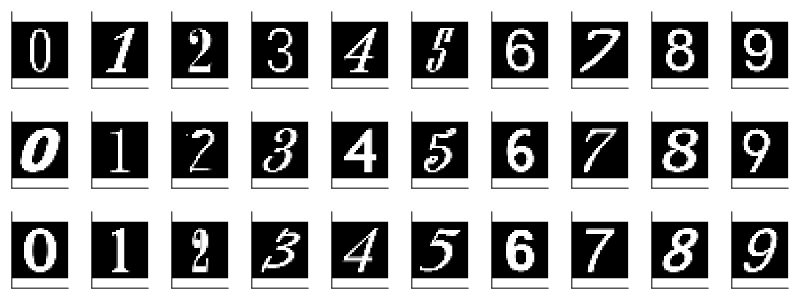

In [ ]:
canvases = []
n_rows = 3

idxs_to_plot = zeros(Int, (n_rows, 10))
# collect data by columns
for j in 0:9
    valid_idxs = collect(1:length(labels))[labels .== j]
    for (i, idx) in enumerate(sample(valid_idxs, n_rows, replace=false))
        idxs_to_plot[i, j + 1] = idx
    end
end
# enter data into canvases by row
for i in 1:n_rows
    for j in 0:9
        idx = idxs_to_plot[i, j + 1]
        canvas = plot(Gray.(data[idx][:, :]))
        push!(canvases, canvas)
    end
end
plot(canvases..., layout=(n_rows, 10), ticks=nothing, border=nothing,  size=(800, 300))

Moving average formula:
$
\begin{align}
\bar{x}_n &= \frac{1}{n}\sum_i^n x_i \\
        &= \frac{\bar{x}_{n-1}(n - 1) + x_n}{n} \\
\end{align}
$

In [ ]:
function moving_average(x::AbstractArray)
    n = 0
    x̄ = zero(first(x))
    for x_i in x
       x̄ = (x̄ * n + x_i)/(n + 1)
       n += 1
    end
    x̄
end

moving_average (generic function with 1 method)

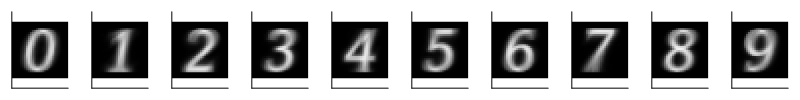

In [ ]:
mean_images = []
canvases = []
for j in 0:9
    mean_img = moving_average(data[labels .== j])
    push!(mean_images, mean_img)
    canvas = plot(Gray.(mean_img[:, :, 1]))
    push!(canvases, canvas)
end
plot(canvases..., layout=(1, 10), ticks=nothing, border=nothing,  size=(800, 100))

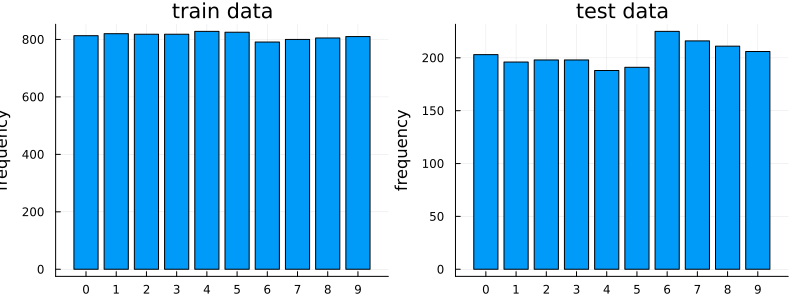

In [ ]:
canvas_test = bar(
    0:9, counts(onecold(y_test, 0:9)), 
    label="", 
    xticks=0:9,
    ylabel="frequency",
    title="test data"
)
canvas_train = bar(
    0:9, counts(onecold(y_train, 0:9)), 
    label="", 
    xticks=0:9,
    ylabel="frequency",
    title="train data"
)

plot(canvas_train, canvas_test, layout = (1, 2), size=(800, 300))

## Load model

Models: 
- cnn_dropout.bson
- cnn_dropout_small.bson
- cnn_Flux.bson
- LeNet5.bson
- nn_simple.bson

In [ ]:
model_path = joinpath("..\\DigitDetection\\models", "LeNet5_20k_e20" * ".bson")
BSON.@load model_path model history
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

Compile model

In [ ]:
model(x_train[:, :, :, 1:10]); 

## Evaluate

### Accuracy

In [ ]:
accuracy(ŷ, y) = mean(onecold(ŷ, 0:9) .== onecold(y, 0:9))
# compile
accuracy(model(x_train[:, :, :, 1:10]), y_train[:, 1:10]) ;

In [ ]:
@time train_accuracy = accuracy(model(x_train), y_train)
@printf "train accuracy for %d samples: %.4f\n" size(x_train, 4) train_accuracy

ŷ = model(x_test)
@time test_accuracy = accuracy(ŷ, y_test)
@printf " test accuracy for %d samples: %.4f" size(x_test, 4) test_accuracy

  0.574817 seconds (140 allocations: 326.194 MiB, 9.52% gc time)
train accuracy for 8128 samples: 0.9948
  0.000145 seconds (11 allocations: 76.500 KiB)
 test accuracy for 2032 samples: 0.9946

### Wrong values

In [ ]:
x, y = Flux.batch(data_mnist), onehotbatch(labels_mnist, 0:9)
ŷ = model(x);
accuracy(ŷ, y)

0.9913

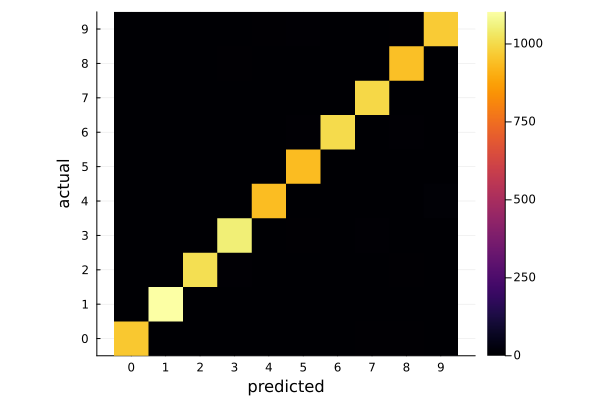

In [ ]:
cm = confusion_matrix(onecold(ŷ, 0:9), onecold(y, 0:9), 0:9)
# for i in 1:size(cm, 1)
#     cm[i, i] = 0
# end
heatmap(cm, aspectratio=1, xlims=(0, 11), ticks=(1:10, 0:9), ylabel="actual", xlabel="predicted")

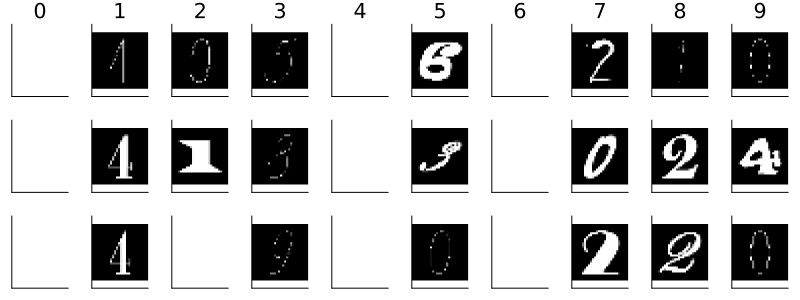

In [ ]:
x, y = Flux.batch(data), labels
n_test = size(x, 4)
ŷ = model(x)
canvases = []
n_rows = 3

wrong_idxs = collect(1:n_test)[onecold(ŷ, 0:9) .!= y];

idxs_to_plot = zeros(Int, (n_rows, 10))
# collect data by columns
for j in 0:9
    j_idxs = wrong_idxs[onecold(ŷ[:, wrong_idxs], 0:9) .== j]
    sample_idxs = length(j_idxs) > n_rows ? sample(j_idxs, n_rows, replace=false) : j_idxs
    for (i, idx) in enumerate(sample_idxs)
        idxs_to_plot[i, j + 1] = idx
    end
end
# enter data into canvases by row
for i in 1:n_rows
    for j in 0:9
        idx = idxs_to_plot[i, j + 1]
        canvas = idx == 0 ? plot() : plot(Gray.(x[:, :, 1, idx]))
        if i == 1 
            plot!(canvas, title=string(j))
        end
        push!(canvases, canvas)
    end
end
plot(canvases..., layout=(n_rows, 10), ticks=nothing, border=nothing,  size=(800, 300))

### Self-knowledge

In [ ]:
ŷ = model(x_test)
probs = maximum(softmax(ŷ), dims=1)
outcome = onecold(ŷ, 0:9) .== onecold(y_test, 0:9);

In [ ]:
canvas = plot()
wrong = (outcome .== 0)
histogram!(canvas, probs[wrong], color=:red, label="wrong")
q2 = median(probs[wrong])
@printf "median wrong probability: %.4f\n" q2*100

correct = (outcome .== 1)
histogram!(canvas, probs[correct], color=:green, label="correct")
q2 = median(probs[correct])
@printf "median correct probability: %.4f" q2*100

canvas

median wrong probability: 64.9059
median correct probability: 100.0000

### Inference time

In [ ]:
elapsed_time = time_ns()
model(x_train)
elapsed_time = time_ns() - elapsed_time

n = size(x_train, 4)
@printf "time per prediction: %.4f ms" (elapsed_time/1e6/n)

time per prediction: 0.0562 ms

## Compare models

In [ ]:
df_models = DataFrame(
    name=["cnn_Flux", "LeNet5", "cnn_medium", "cnn_small", "nn_fc", "cnn_mastery", "cnn_huge"], 
    train_accuracy=[0.9964, 0.9951, 0.9937, 0.9862, 0.9843, 0.9999, 0.9926],
    test_accuracy=[0.9862, 0.9867, 0.9867, 0.9774, 0.9675, 0.9877, 0.9813],
    inference_time=[0.2885, 0.0806, 0.1355, 0.0576, 0.0023, 0.1547, 0.8164], #ms
    file_size=[101, 183, 79.4, 27.7, 103, 2.07*1024, 4.58*1024],
    parameters=[16_938, 44_426, 18_378, 5_142, 25_450, 542_230, 1_199_882]
)
;

In [ ]:
names = ["LeNet5", "cnn_medium", "cnn_small", "nn_fc", "cnn_mastery", "cnn_huge"]
df = filter(row -> row["name"] ∈ names, df_models)
sort!(df, [order(:test_accuracy, rev=true), order(:inference_time)])

Row,name,train_accuracy,test_accuracy,inference_time,file_size,parameters
,String,Float64,Float64,Float64,Float64,Int64
1,cnn_mastery,0.9999,0.9877,0.1547,2119.68,542230
2,LeNet5,0.9951,0.9867,0.0806,183.0,44426
3,cnn_medium,0.9937,0.9867,0.1355,79.4,18378
4,cnn_huge,0.9926,0.9813,0.8164,4689.92,1199882
5,cnn_small,0.9862,0.9774,0.0576,27.7,5142
6,nn_fc,0.9843,0.9675,0.0023,103.0,25450
